In [6]:
import numpy as np
import scipy.stats as stats
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def parse_triangle(df, condition='upper'):
    '''
    This function grabs the upper triangle of a correlation matrix
    by masking out the bottom triangle (tril) and returns the values. 
    
    df: pandas or numpy correlation matrix
    condition: 'upper': grabs the upper triangle
               'pairs': grabs pair of subjects, skiiping each diagonal
               'nonpairs': grabs nonpairs, upper - pairs 
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.as_matrix()
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    if condition =='upper':
        mask = np.triu_indices(df.shape[0], k=1)
        return df[mask] 
    else:
        noDyads = int(df.shape[0]/2)
        if condition =='pairs':
            return np.diag(df,k=1)[range(0,noDyads*2,2)]
        elif condition =='nonpairs':
            mask = np.triu(np.ones(df.shape),k=1).astype(np.bool)
            ix, iy = np.arange(0,noDyads*2,2), np.arange(1,noDyads*2,2)
            for i in np.arange(0,len(ix)):
                mask[ix[i],iy[i]] = False
            return df[mask]
        else:
            raise ValueError('Condition,'+ str(condition) +' not recognized')


Bad key "ckend" on line 1 in
/Users/jinhyuncheong/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [78]:
n = 1000 
u = 0
v = .1

n_sim = 10000
m_ps = np.empty(n_sim)
for i in range(n_sim):
    # Create two normal distributions with size n, mean u, variance v     
    x = np.random.normal(loc = u, scale = v, size = n)
    y = np.random.normal(loc = u, scale = v, size = n)
    # Mean diff of two vectors
    (_,p) = stats.ttest_ind(x,y)
    m_ps[i] = p
# Print FPR
fpr = np.sum(np.array(m_ps)<.05) / n_sim
print('FPR of mean difference: ', fpr)

FPR of mean difference:  0.0465


In [145]:
n = 10
corrs = np.random.normal(loc=0,scale=1,size=int(n*(n-1)/2))

r1 = pd.DataFrame(easy_multivariate_normal(50,n,corrs=corrs)).corr()
v_r1 = parse_triangle(r1) # vectorized r1
# create matrix that is 

Correlation matrix is not positive semi-definite. Solved for new correlation matrix.


In [ ]:
# The serial version- takes long time.
n=10
is_rsa = 0. # this is the correlation between two RSA matrices.
rs = []
ps = []
n_sim = 5000
for i in range(n_sim):
    # This gives vectorized values for two squareform
    rsas = easy_multivariate_normal(num_obs=int(n*(n-1)/2),num_features=2,corrs=is_rsa)
    x,y = rsas[:,0], rsas[:,1]
    # find nearest because each needs to be Positive semi definite.
    x = parse_triangle(np.array(_nearestPD(squareform(x))))
    y = parse_triangle(np.array(_nearestPD(squareform(y))))
    # recalculate pearsonr
    r,p = stats.pearsonr(x,y)
    rs.append(r)
    ps.append(p)  

In [188]:
np.sum(np.array(ps)<.05) /len(ps)

0.049835931091058244

In [203]:
def calc_rsa(n,is_rsa,seed):
    '''
    n = number of subjects
    is_rsa = correlation between two rsa matrices, 0.
    seed: random seed
    '''
    # This gives vectorized values for two squareform
    rsas = easy_multivariate_normal(num_obs=int(n*(n-1)/2),num_features=2,corrs=is_rsa,seed=seed)
    x,y = rsas[:,0], rsas[:,1]
    o_r,o_p = stats.pearsonr(x,y)
    # find nearest because each needs to be Positive semi definite.
    x = parse_triangle(np.array(_nearestPD(squareform(x))))
    y = parse_triangle(np.array(_nearestPD(squareform(y))))
    # recalculate pearsonr
    r,p = stats.pearsonr(x,y)
    return r,p,o_r,o_p

In [204]:
from joblib import Parallel, delayed
results = Parallel(n_jobs = -2)(delayed(calc_rsa)(n, is_rsa, seed) for seed in range(n_sim))

In [206]:
rs, ps, o_rs, o_ps = zip(*results)
fpr = np.sum(np.array(ps)<.05) /len(ps)
print('False Positive Rate with PD: ', fpr)
fpr = np.sum(np.array(o_ps)<.05) /len(o_ps)
print('False Positive Rate without PD: ', fpr)

False Positive Rate with PD:  0.045
False Positive Rate without PD:  0.0472


In [193]:
results = Parallel(n_jobs = -2)(delayed(calc_rsa)(n, is_rsa, seed) for seed in range(n_sim))

In [195]:
rs, ps = zip(*results)
fpr = np.sum(np.array(ps)<.05) /len(ps)
print(fpr)

0.045


In [ ]:
n=10
is_rsa = 0.
rs = []
ps = []
n_sim = 1000
for i in range(n_sim):
    r = .1
    while abs(r) > .005: 
        rsas = easy_multivariate_normal(num_obs=int(n*(n-1)/2),num_features=2,corrs=is_rsa)
        x,y = rsas[:,0], rsas[:,1]
        x = parse_triangle(np.array(_nearestPD(squareform(x))))
        y = parse_triangle(np.array(_nearestPD(squareform(y))))
        r,p = stats.pearsonr(x,y)
    rs.append(r)
    ps.append(p)
    print(i)

In [ ]:
np.matrix()

In [1]:
from scipy.spatial.distance import squareform
def isPSD(A, tol=1e-100):
    E,V = np.linalg.eigh(A)
    return np.all(E > -tol)
def _nearestPD(A, nit=100):
    """
    Higham (2000) algorithm to find the nearest positive semi-definite matrix that minimizes the Frobenius distance/norm. Pretty sure this is what statsmodels uses, in corr_nearest. Reference: https://goo.gl/Eut7UU

    Args:
        nit (int): number of iterations to run algorithm; more iterations improves accuracy but increases computation time.
    """

    n = A.shape[0]
    W = np.identity(n)

    def _getAplus(A):
        eigval, eigvec = np.linalg.eig(A)
        Q = np.matrix(eigvec)
        xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
        return Q*xdiag*Q.T

    def _getPs(A, W=None):
        W05 = np.matrix(W**.5)
        return  W05.I * _getAplus(W05 * A * W05) * W05.I

    def _getPu(A, W=None):
        Aret = np.array(A.copy())
        Aret[W > 0] = np.array(W)[W > 0]
        return np.matrix(Aret)

    # W is the matrix used for the norm (assumed to be Identity matrix here)
    # the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

def easy_multivariate_normal(num_obs, num_features, corrs, mu = 0.0, sigma = 1.0, seed = None,forcePD=True,return_new_corrs=False):
    """
    Function to more easily generate multivariate normal samples provided a correlation matrix or list of correlations (upper triangle of correlation matrix) instead of a covariance matrix. Defaults to returning approximately standard normal (mu = 0; sigma = 1) variates. Unlike numpy, if the desired correlation matrix is not positive semi-definite, will by default issue a warning and find the nearest correlation matrix that is by default. This new matrix can optionally be returned used the return_new_corrs argument.

    Args:
        num_obs (int): number of observations/samples to generate (rows)
        corrs (ndarray): num_features x num_features or flattend numpy array of length (num_features * (num_features-1)) / 2
        num_features (int): number of features/variables/dimensions to generate (columns)
        mu (float/list): mean of each feature across observations; default 0.0
        sigma (float/list): sd of each feature across observations; default 1.0
        forcePD (bool): whether to find and use a new correlation matrix if the requested one is not positive semi-definite; default False
        return_new_corrs (bool): return the nearest correlation matrix that is positive semi-definite used to generate data; default False

    Returns:
        ndarray: correlated data as num_obs x num_features array
    """

    if seed is not None:
        np.random.seed(seed)

    if isinstance(mu, list):
        assert len(mu) == num_features, "Number of means must match number of features"
    else:
        mu = [mu] * num_features
    if isinstance(sigma, list):
        assert len(sigma) == num_features, "Number of sds must match number of features"
    else:
        sigma = [sigma] * num_features

    if isinstance(corrs,np.ndarray) and corrs.ndim == 2:
        assert corrs.shape[0] == corrs.shape[1] and np.allclose(corrs,corrs.T) and np.allclose(np.diagonal(corrs),np.ones_like(np.diagonal(corrs))), "Correlation matrix must be square symmetric"
    elif (isinstance(corrs,np.ndarray) and corrs.ndim == 1) or isinstance(corrs,list):
        assert len(corrs) == (num_features * (num_features-1)) / 2, "(num_features * (num_features - 1) / 2) correlation values are required for a flattened array or list"
        corrs = squareform(corrs)
        np.fill_diagonal(corrs,1.0)
    elif isinstance(corrs,float):
        corrs = np.array([corrs] * int(((num_features * (num_features-1)) / 2)))
        corrs = squareform(corrs)
        np.fill_diagonal(corrs,1.0)
    else:
        raise ValueError("Correlations must be num_features x num_feature, flattend numpy array/list or scalar")

    if not isPSD(corrs):
        if forcePD:
            # Tell user their correlations are being recomputed if they didnt ask to save them as they might not realize
            if not return_new_corrs:
                print("Correlation matrix is not positive semi-definite. Solved for new correlation matrix.")
            _corrs = np.array(_nearestPD(corrs))

        else:
            raise ValueError("Correlation matrix is not positive semi-definite. Pymer4 will not generate inaccurate multivariate data. Use the forcePD argument to automatically solve for the closest desired correlation matrix.")
    else:
        _corrs = corrs

    #Rescale correlation matrix by variances, given standard deviations of features
    sd = np.diag(sigma)
    #R * Vars = R * SD * SD
    cov = _corrs.dot(sd.dot(sd))
    X = np.random.multivariate_normal(mu, cov, size = num_obs)

    if return_new_corrs:
        return X, _corrs
    else:
        return X

# Monte Carlo simulation

In [20]:
# Create a dataset 
n=1000
is_rsa = 0. # this is the correlation between two RSA matrices.
rs = []
ps = []
n_sim = 5000
r=.1
while abs(r)>.05:
    # This gives vectorized values for two matrices
    rsas = easy_multivariate_normal(num_obs=int(n*(n-1)/2),num_features=2,corrs=is_rsa)
    x,y = rsas[:,0], rsas[:,1]
    # find nearest because each needs to be Positive semi definite.
    x = parse_triangle(np.array(_nearestPD(squareform(x))))
    y = parse_triangle(np.array(_nearestPD(squareform(y))))
    # recalculate matrix similarity
    r,p = stats.spearmanr(x,y) 

In [16]:
np.mean(np.matrix(squareform(y)).getH() == squareform(y))

1.0

In [211]:
x = np.array(x)
y = np.array(y)

In [215]:
x_mat = pd.DataFrame(squareform(x))
y_mat = pd.DataFrame(squareform(y))

In [2]:
def calc_fpr(n_size,seed):
    np.random.seed(seed=seed)
    n_sim = 5000
    sim_rs, sim_ps = np.empty(n_sim),np.empty(n_sim)
    for i in range(n_sim):
        new_subs = np.random.choice(range(n),size=n_size,replace=False)
        new_x_vec = parse_triangle(x_mat.iloc[new_subs,new_subs])
        new_y_vec = parse_triangle(y_mat.iloc[new_subs,new_subs])
        sim_r, sim_p = stats.spearmanr(new_x_vec,new_y_vec)
        sim_rs[i]=sim_r
        sim_ps[i]=sim_p
    fpr = np.sum(sim_ps < .05)/len(sim_ps)
    return fpr

In [271]:
n_size = 10
n_sim_fpr = 100
results = Parallel(n_jobs=-2)(delayed(calc_fpr)(n_size,seed) for seed in range(n_sim_fpr))

In [275]:
results_10 = results.copy()

In [276]:
n_size = 30
n_sim_fpr = 100
results_30 = Parallel(n_jobs=-2)(delayed(calc_fpr)(n_size,seed) for seed in range(n_sim_fpr))

In [277]:
np.mean(results_30)

0.049946000000000004

# Test for group difference case

In [9]:
_,sim_p = stats.ttest_1samp(new_x_vec,new_y_vec)

NameError: name 'new_x_vec' is not defined

In [7]:
def calc_fpr_ttest(n_size,seed):
    np.random.seed(seed=seed)
    n_sim = 5000
    sim_rs, sim_ps = np.empty(n_sim),np.empty(n_sim)
    for i in range(n_sim):
        new_subs = np.random.choice(range(n),size=n_size,replace=False)
        new_x_vec = parse_triangle(x_mat.iloc[new_subs,new_subs])
        new_y_vec = parse_triangle(y_mat.iloc[new_subs,new_subs])
        _,sim_p = stats.ttest_1samp(new_x_vec-new_y_vec,0)
        sim_ps[i]=sim_p
    fpr = np.sum(sim_ps < .05)/len(sim_ps)
    return fpr

In [10]:
n_size = 30
n_sim_fpr = 100
results_30 = Parallel(n_jobs=-2)(delayed(calc_fpr_ttest)(n_size,seed) for seed in range(n_sim_fpr))

JoblibNameError: JoblibNameError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10cbaf9c0, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/jinhyuncheong/anaconda2/envs/py36/lib/pyt...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/jinhy.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10cbaf9c0, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/jinhyuncheong/anaconda2/envs/py36/lib/pyt...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/jinhy.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 7, 16, 41, 40, 921034, tzinfo=tzlocal()), 'msg_id': '1BEFF2D2E1394F9B9BF6BD90CFF43D8C', 'msg_type': 'execute_request', 'session': '48585D22C9FF43E88E186C571A5CD764', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '1BEFF2D2E1394F9B9BF6BD90CFF43D8C', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'48585D22C9FF43E88E186C571A5CD764']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 7, 16, 41, 40, 921034, tzinfo=tzlocal()), 'msg_id': '1BEFF2D2E1394F9B9BF6BD90CFF43D8C', 'msg_type': 'execute_request', 'session': '48585D22C9FF43E88E186C571A5CD764', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '1BEFF2D2E1394F9B9BF6BD90CFF43D8C', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'48585D22C9FF43E88E186C571A5CD764'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 7, 16, 41, 40, 921034, tzinfo=tzlocal()), 'msg_id': '1BEFF2D2E1394F9B9BF6BD90CFF43D8C', 'msg_type': 'execute_request', 'session': '48585D22C9FF43E88E186C571A5CD764', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '1BEFF2D2E1394F9B9BF6BD90CFF43D8C', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-10-04cd3f427d02>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1136e5470, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1137d7420, file "<ipython-input-10-04cd3f427d02>", line 3>
        result = <ExecutionResult object at 1136e5470, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1137d7420, file "<ipython-input-10-04cd3f427d02>", line 3>, result=<ExecutionResult object at 1136e5470, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1137d7420, file "<ipython-input-10-04cd3f427d02>", line 3>
        self.user_global_ns = {'In': ['', 'from scipy.spatial.distance import squareform\nde...      return X, _corrs\n    else:\n        return X', 'def calc_fpr(n_size,seed):\n    np.random.seed(se...= np.sum(sim_ps < .05)/len(sim_ps)\n    return fpr', 'def calc_fpr_ttest(n_size,seed):\n    np.random.s...= np.sum(sim_ps < .05)/len(sim_ps)\n    return fpr', 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', 'np.mean(results_30)', "import numpy as np\nimport scipy.stats as stats\ni...('Condition,'+ str(condition) +' not recognized')", 'def calc_fpr_ttest(n_size,seed):\n    np.random.s...= np.sum(sim_ps < .05)/len(sim_ps)\n    return fpr', 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', '_,sim_p = stats.ttest_1samp(new_x_vec,new_y_vec)', 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))'], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__loader__': None, ...}
        self.user_ns = {'In': ['', 'from scipy.spatial.distance import squareform\nde...      return X, _corrs\n    else:\n        return X', 'def calc_fpr(n_size,seed):\n    np.random.seed(se...= np.sum(sim_ps < .05)/len(sim_ps)\n    return fpr', 'def calc_fpr_ttest(n_size,seed):\n    np.random.s...= np.sum(sim_ps < .05)/len(sim_ps)\n    return fpr', 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', 'np.mean(results_30)', "import numpy as np\nimport scipy.stats as stats\ni...('Condition,'+ str(condition) +' not recognized')", 'def calc_fpr_ttest(n_size,seed):\n    np.random.s...= np.sum(sim_ps < .05)/len(sim_ps)\n    return fpr', 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))', '_,sim_p = stats.ttest_1samp(new_x_vec,new_y_vec)', 'n_size = 30\nn_sim_fpr = 100\nresults_30 = Paralle...ttest)(n_size,seed) for seed in range(n_sim_fpr))'], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__loader__': None, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/jinhyuncheong/Dropbox/jcheong0428.github.io/_Notebooks/is_rsa_simulation/<ipython-input-10-04cd3f427d02> in <module>()
      1 n_size = 30
      2 n_sim_fpr = 100
----> 3 results_30 = Parallel(n_jobs=-2)(delayed(calc_fpr_ttest)(n_size,seed) for seed in range(n_sim_fpr))

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-2), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
NameError                                          Fri Sep  7 16:41:40 2018
PID: 44193Python 3.6.1: /Users/jinhyuncheong/anaconda2/envs/py36/bin/python
...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function calc_fpr_ttest>, (30, 0), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function calc_fpr_ttest>
        args = (30, 0)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/jinhyuncheong/Dropbox/jcheong0428.github.io/_Notebooks/is_rsa_simulation/<ipython-input-7-408618b68b45> in calc_fpr_ttest(n_size=30, seed=0)
      1 def calc_fpr_ttest(n_size,seed):
      2     np.random.seed(seed=seed)
      3     n_sim = 5000
      4     sim_rs, sim_ps = np.empty(n_sim),np.empty(n_sim)
      5     for i in range(n_sim):
----> 6         new_subs = np.random.choice(range(n),size=n_size,replace=False)
      7         new_x_vec = parse_triangle(x_mat.iloc[new_subs,new_subs])
      8         new_y_vec = parse_triangle(y_mat.iloc[new_subs,new_subs])
      9         _,sim_p = stats.ttest_1samp(new_x_vec-new_y_vec,0)
     10         sim_ps[i]=sim_p

NameError: name 'n' is not defined
___________________________________________________________________________

In [5]:
np.mean(results_30)

NameError: name 'np' is not defined

In [287]:
rho = .3
p = [[1,rho,rho,rho,rho,rho,rho,0,0,0],
     [rho,1,rho,rho,rho,0,0,rho,rho,0],
     [rho,rho,1,rho,0,rho,0,rho,0,rho],
     [rho,rho,rho,1,0,0,rho,0,rho,rho],
     [rho,rho,0,0,1,rho,rho,rho,rho,0],
     [rho,0,rho,0,rho,1,rho,rho,0,rho],
     [rho,0,0,rho,rho,rho,1,0,rho,rho],
     [0,rho,rho,0,rho,rho,0,1,rho,rho],
     [0,rho,0,rho,rho,0,rho,rho,1,rho],
     [0,0,rho,rho,0,rho,rho,rho,rho,1]]

In [384]:
g = pd.DataFrame(easy_multivariate_normal(1000,corrs=parse_triangle(np.array(p)),num_features=10,forcePD=True)).corr()
np.median(parse_triangle(g))


0.2973244265813118

In [11]:
n_size = 10
n_sim_fpr = 100
fprs = np.empty(n_sim_fpr)
for fpr_i in range(n_sim_fpr):
    n_sim = 5000
    sim_rs, sim_ps = np.empty(n_sim),np.empty(n_sim)
    for i in range(5000):
        new_subs = np.random.choice(range(1000),size=10,replace=False)
        new_x_vec = parse_triangle(x_mat.iloc[new_subs,new_subs])
        new_y_vec = parse_triangle(y_mat.iloc[new_subs,new_subs])
        sim_r, sim_p = stats.spearmanr(new_x_vec,new_y_vec)
        sim_rs[i]=sim_r
        sim_ps[i]=sim_p
    fpr = np.sum(sim_ps < .05)/len(sim_ps)
    fprs[fpr_i]=fpr
    break;

NameError: name 'x_mat' is not defined

In [269]:
np.random.seed(seed=2)
np.random.choice(range(10),2,replace=False)

array([4, 1])

In [ ]:
# Fonew_x_vecr 5000 datasets, generate two correlation matrix with 0 correlation 

# For each dataset, test how many say that the correlation is significant. 


jackknife


In [49]:
data1 = np.random.rand(100,10)
data2 = np.random.rand(100,10)
isPSD(squareform(pdist(data1,metric='euclidean')))

False

In [50]:
isPSD(pd.DataFrame(data1).corr())

True

In [26]:
data1 = pd.DataFrame(np.random.rand(100,10)).corr().as_matrix()
data2 = pd.DataFrame(np.random.rand(100,10)).corr().as_matrix()
stat = {}
stat['all_r']=[]
for s in range(data1.shape[0]):
    func = stats.spearmanr
    stat['all_r'].append(func(np.delete(data1[s,],s), np.delete(data2[s,], s))[0])

In [16]:
from scipy.spatial.distance import pdist
from nltools.stats import _calc_pvalue
ps_mantel,ps_jackknife,ps_regular = [],[],[]
for i in range(500):
    data1 = pdist(pd.DataFrame(np.random.rand(100,20)))
    data2 = pdist(pd.DataFrame(np.random.rand(100,20)))
    out = test(data1,data2,perms=5000,method='spearman',tail='two-tail')
#     print('Mantel',test(data1,data2,perms=5000,method='spearman',tail='two-tail'))
    ps_mantel.append(out[1])
#     regular naive p value
    ps_regular.append(stats.spearmanr(data1,data2)[1])
    data1 = squareform(data1)
    data2 = squareform(data2)
    stat = {}
    stat['all_r']=[]
    for s in range(data1.shape[0]):
        func = stats.spearmanr
        stat['all_r'].append(func(np.delete(data1[s,],s), np.delete(data2[s,], s))[0])
    stat['correlation'] = np.mean(stat['all_r'])
    all_p = Parallel(n_jobs=-2)(delayed(np.mean)(
    stat['all_r']*np.random.choice([1,-1],len(stat['all_r']))) for i in range(5000))
    stat['p'] = _calc_pvalue(all_p, stat['correlation'], 2)
#     print(stat['correlation'],stat['p'])
    ps_jackknife.append(stat['p'])

In [17]:
print('FPR naive:',np.sum(np.array(ps_regular)<.05)/len(ps_regular))
print('FPR mantel:',np.sum(np.array(ps_mantel)<.05)/len(ps_mantel))
print('FPR jackknife:',np.sum(np.array(ps_jackknife)<.05)/len(ps_jackknife))

FPR naive: 0.324
FPR mantel: 0.03
FPR jackknife: 0.284


In [98]:
np.random.multivariate_normal?

In [100]:
dat = np.random.multivariate_normal([5, 10, 15, 25, 35, 45],
	                                    [[1, .2, .5, .7, .8, .9],
	                                     [.2, 1, .4, .1, .1, .1],
	                                     [.5, .4, 1, .1, .1, .1],
	                                     [.7, .1, .1, 1, .3, .6],
	                                     [.8, .1, .1, .3, 1, .5],
	                                     [.9, .1, .1, .6, .5, 1]], 200)
dat = dat + np.random.randn(dat.shape[0],dat.shape[1])*.5

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


In [104]:
pd.DataFrame(dat).cov()

,0,1,2,3,4,5
0,1.524986,0.319274,0.499928,0.746235,0.932289,0.932915
1,0.319274,1.607496,0.374572,0.163862,0.377669,0.271171
2,0.499928,0.374572,1.281833,0.078201,0.215726,0.265442
3,0.746235,0.163862,0.078201,1.234554,0.454493,0.612230
4,0.932289,0.377669,0.215726,0.454493,1.323769,0.598898
5,0.932915,0.271171,0.265442,0.612230,0.598898,1.225627


(array([209.,  58.,  54.,  31.,  23.,  37.,  24.,  24.,  23.,  17.]),
 array([0.     , 0.09924, 0.19848, 0.29772, 0.39696, 0.4962 , 0.59544,
        0.69468, 0.79392, 0.89316, 0.9924 ]),
 <a list of 10 Patch objects>)

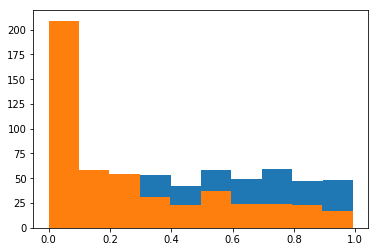

In [90]:
plt.hist(ps_mantel)
plt.hist(ps_jackknife)

In [14]:
import numpy as np
from itertools import permutations
from scipy import spatial, stats

def test(X, Y, perms=10000, method='pearson', tail='two-tail'):
  """
  Takes two distance matrices (either redundant matrices or condensed vectors)
  and performs a Mantel test. The Mantel test is a significance test of the
  correlation between two distance matrices.
  Parameters
  ----------
  X : array_like
      First distance matrix (condensed or redundant).
  Y : array_like
      Second distance matrix (condensed or redundant), where the order of
      elements corresponds to the order of elements in the first matrix.
  perms : int, optional
      The number of permutations to perform (default: 10000). A larger number
      gives more reliable results but takes longer to run. If the actual number
      of possible permutations is smaller, the program will enumerate all
      permutations. Enumeration can be forced by setting this argument to 0.
  method : str, optional
      Type of correlation coefficient to use; either 'pearson' or 'spearman'
      (default: 'pearson').
  tail : str, optional
      Which tail to test in the calculation of the empirical p-value; either
      'upper', 'lower', or 'two-tail' (default: 'two-tail').
  Returns
  -------
  r : float
      Veridical correlation
  p : float
      Empirical p-value
  z : float
      Standard score (z-score)
  """

  # Ensure that X and Y are formatted as Numpy arrays.
  X, Y = np.asarray(X, dtype=float), np.asarray(Y, dtype=float)

  # Check that X and Y are valid distance matrices.
  if spatial.distance.is_valid_dm(X) == False and spatial.distance.is_valid_y(X) == False:
    raise ValueError('X is not a valid condensed or redundant distance matrix')
  if spatial.distance.is_valid_dm(Y) == False and spatial.distance.is_valid_y(Y) == False:
    raise ValueError('Y is not a valid condensed or redundant distance matrix')

  # If X or Y is a redundant distance matrix, reduce it to a condensed distance matrix.
  if len(X.shape) == 2:
    X = spatial.distance.squareform(X, force='tovector', checks=False)
  if len(Y.shape) == 2:
    Y = spatial.distance.squareform(Y, force='tovector', checks=False)

  # Check for size equality.
  if X.shape[0] != Y.shape[0]:
    raise ValueError('X and Y are not of equal size')

  # Check for minimum size.
  if X.shape[0] < 3:
    raise ValueError('X and Y should represent at least 3 objects')

  # If Spearman correlation is requested, convert X and Y to ranks.
  if method == 'spearman':
    X, Y = stats.rankdata(X), stats.rankdata(Y)

  # Check for valid method parameter.
  elif method != 'pearson':
    raise ValueError('The method should be set to "pearson" or "spearman"')

  # Check for valid tail parameter.
  if tail != 'upper' and tail != 'lower' and tail != 'two-tail':
    raise ValueError('The tail should be set to "upper", "lower", or "two-tail"')

  # Now we're ready to start the Mantel test using a number of optimizations:
  #
  # 1. We don't need to recalculate the pairwise distances between the objects
  #    on every permutation. They've already been calculated, so we can use a
  #    simple matrix shuffling technique to avoid recomputing them. This works
  #    like memoization.
  #
  # 2. Rather than compute correlation coefficients, we'll just compute the
  #    covariances. This works because the denominator in the equation for the
  #    correlation coefficient will yield the same result however the objects
  #    are permuted, making it redundant. Removing the denominator leaves us
  #    with the covariance.
  #
  # 3. Rather than permute the Y distances and derive the residuals to calculate
  #    the covariance with the X distances, we'll represent the Y residuals in
  #    the matrix and shuffle those directly.
  #
  # 4. If the number of possible permutations is less than the number of
  #    permutations that were requested, we'll run a deterministic test where
  #    we try all possible permutations rather than sample the permutation
  #    space. This gives a faster, deterministic result.

  # Calculate the X and Y residuals, which will be used to compute the
  # covariance under each permutation.
  X_residuals, Y_residuals = X - X.mean(), Y - Y.mean()

  # Expand the Y residuals to a redundant matrix.
  Y_residuals_as_matrix = spatial.distance.squareform(Y_residuals, force='tomatrix', checks=False)

  # Get the number of objects.
  m = Y_residuals_as_matrix.shape[0]

  # Calculate the number of possible matrix permutations.
  n = np.math.factorial(m)

  # Initialize an empty array to store temporary permutations of Y_residuals.
  Y_residuals_permuted = np.zeros(Y_residuals.shape[0], dtype=float)

  # If the number of requested permutations is greater than the number of
  # possible permutations (m!) or the perms parameter is set to 0, then run a
  # deterministic Mantel test ...
  if perms >= n or perms == 0:

    # Initialize an empty array to store the covariances.
    covariances = np.zeros(n, dtype=float)

    # Enumerate all permutations of row/column orders and iterate over them.
    for i, order in enumerate(permutations(range(m))):

      # Take a permutation of the matrix.
      Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

      # Condense the permuted version of the matrix. Rather than use
      # distance.squareform(), we call directly into the C wrapper for speed.
      spatial.distance._distance_wrap.to_vector_from_squareform_wrap(Y_residuals_as_matrix_permuted, Y_residuals_permuted)

      # Compute and store the covariance.
      covariances[i] = (X_residuals * Y_residuals_permuted).sum()

  # ... otherwise run a stochastic Mantel test.
  else:

    # Initialize an empty array to store the covariances.
    covariances = np.zeros(perms, dtype=float)

    # Initialize an array to store the permutation order.
    order = np.arange(m)

    # Store the veridical covariance in 0th position...
    covariances[0] = (X_residuals * Y_residuals).sum()

    # ...and then run the random permutations.
    for i in range(1, perms):

      # Choose a random order in which to permute the rows and columns.
      np.random.shuffle(order)

      # Take a permutation of the matrix.
      Y_residuals_as_matrix_permuted = Y_residuals_as_matrix[order, :][:, order]

      # Condense the permuted version of the matrix. Rather than use
      # distance.squareform(), we call directly into the C wrapper for speed.
      spatial.distance._distance_wrap.to_vector_from_squareform_wrap(Y_residuals_as_matrix_permuted, Y_residuals_permuted)

      # Compute and store the covariance.
      covariances[i] = (X_residuals * Y_residuals_permuted).sum()

  # Calculate the veridical correlation coefficient from the veridical covariance.
  r = covariances[0] / np.sqrt((X_residuals ** 2).sum() * (Y_residuals ** 2).sum())

  # Calculate the empirical p-value for the upper or lower tail.
  if tail == 'upper':
    p = (covariances >= covariances[0]).sum() / float(covariances.shape[0])
  elif tail == 'lower':
    p = (covariances <= covariances[0]).sum() / float(covariances.shape[0])
  elif tail == 'two-tail':
    p = (abs(covariances) >= abs(covariances[0])).sum() / float(covariances.shape[0])

  # Calculate the standard score.
  z = (covariances[0] - covariances.mean()) / covariances.std()

  return r, p, z